In [2]:
# Auto-reload modules for easier debugging
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path so we can import our modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from data_loader import CreditDataLoader
from lending_club_preprocessing import LendingClubPreprocessor
from feature_engineering import FeatureEngineer  
from models import CreditRiskModels
from risk_metrics import RiskMetrics, IFRS9Calculator
from visualization import RiskVisualizer
from moc import ModelOfCredit
from monitoring import ModelMonitor

# Plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Initialize Loader
data_path = "../data"
loader = CreditDataLoader(data_path=data_path)

# Load Data
print("Loading dataset...")
datasets = loader.load_lending_club(accepted_only=True)
accepted_df = datasets.get('accepted')

print(f"Loaded shape: {accepted_df.shape}")

Loading dataset...


INFO:data_loader:Loaded Lending Club accepted: (2260701, 151)


Loaded shape: (2260701, 151)


In [4]:
# Preprocess Data
lc_prep = LendingClubPreprocessor()
df_prepared = lc_prep.prepare_accepted(accepted_df)

# CRITICAL FIX: Reset index to ensure alignment and avoid "not in index" errors
df_prepared = df_prepared.reset_index(drop=True)

print(f"Prepared shape: {df_prepared.shape}")
display(df_prepared.head())

Prepared shape: (1345750, 116)


,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,disbursement_method,mths_since_last_delinq_missing,mths_since_last_record_missing,mths_since_last_major_derog_missing,revol_util_missing,dti_missing,annual_inc_missing,default,fico_avg,credit_history_len_months,pmt_to_inc,log_annual_inc
0,3600.0,3600.0,3600.0,36 months,123.03,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,n,debt_consolidation,PA,5.91,0.0,2003-08-01,675.0,679.0,1.0,30.0,0.0,7.0,0.0,2765.0,0.297,13.0,w,564.0,560.0,0.0,30.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0,1,0,0,0,0,0,677.0,147.996058,0.026843,10.915107
1,24700.0,24700.0,24700.0,36 months,820.28,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,n,small_business,SD,16.06,1.0,1999-12-01,715.0,719.0,4.0,6.0,0.0,22.0,0.0,21470.0,0.192,38.0,w,699.0,695.0,0.0,0.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0,1,1,0,0,0,0,717.0,191.984231,0.151436,11.082158
2,20000.0,20000.0,20000.0,60 months,432.66,10+ years,MORTGAGE,63000.0,Not Verified,2015-12-01,n,home_improvement,IL,10.78,0.0,2000-08-01,695.0,699.0,0.0,0.0,0.0,6.0,0.0,7869.0,0.562,18.0,w,704.0,700.0,0.0,0.0,Joint App,71000.0,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,1,1,1,0,0,0,0,697.0,183.968463,0.082411,11.050906
3,10400.0,10400.0,10400.0,60 months,289.91,3 years,MORTGAGE,104433.0,Source Verified,2015-12-01,n,major_purchase,PA,25.37,1.0,1998-06-01,695.0,699.0,3.0,12.0,0.0,12.0,0.0,21929.0,0.645,35.0,w,704.0,700.0,0.0,0.0,Individu

In [5]:
fe = FeatureEngineer()

print("Creating risk features...")
df_features = fe.create_risk_features(df_prepared)
df_features = fe.create_interaction_features(df_features, max_interactions=5)
df_features = fe.create_behavioral_features(df_features)

print("Handling missing values...")
df_imputed = fe.handle_missing_values(df_features)

print("Encoding categoricals...")
df_encoded = fe.encode_categorical_features(df_imputed, target_col='default')

print(f"Final feature set shape: {df_encoded.shape}")




Creating risk features...
Handling missing values...
Encoding categoricals...
Final feature set shape: (1345750, 769)


In [14]:
# Feature Selection
# DROP LEAKY FEATURES explicitly
leakage_cols = ['last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'total_pymnt']
cols_to_drop = ['default'] + [c for c in leakage_cols if c in df_encoded.columns]

X = df_encoded.drop(columns=cols_to_drop, errors='ignore')
y = df_encoded['default']

# Select top 20 features using Mutual Information
print("Selecting top 20 features (excluding leakage)...")
X_selected_df, selected_features = fe.select_features(X, y, method='mutual_info', k=20)

print("Top Selected Features:")
print(selected_features)

INFO:feature_engineering:Selecting top 20 features using mutual_info...


Selecting top 20 features (excluding leakage)...


INFO:feature_engineering:Selected features: ['funded_amnt', 'funded_amnt_inv', 'installment', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'dti_joint', 'open_il_12m', 'acc_open_past_24mths', 'mths_since_recent_bc_dlq', 'num_sats', 'num_tl_90g_dpd_24m', 'tot_hi_cred_lim', 'sec_app_fico_range_low', 'dti_missing', 'fico_avg', 'pmt_to_inc', 'log_annual_inc', 'loan_to_income']


Top Selected Features:
['funded_amnt', 'funded_amnt_inv', 'installment', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'dti_joint', 'open_il_12m', 'acc_open_past_24mths', 'mths_since_recent_bc_dlq', 'num_sats', 'num_tl_90g_dpd_24m', 'tot_hi_cred_lim', 'sec_app_fico_range_low', 'dti_missing', 'fico_avg', 'pmt_to_inc', 'log_annual_inc', 'loan_to_income']


In [15]:
models = CreditRiskModels(random_state=42)

# Prepare splits (Train/Val/Test)
df_for_model = X_selected_df.copy()
df_for_model['default'] = y.values

data_splits = models.prepare_data(df_for_model, 'default', test_size=0.3)

print(f"Train size: {data_splits['X_train'].shape}")
print(f"Val size:   {data_splits['X_val'].shape}")
print(f"Test size:  {data_splits['X_test'].shape}")

# Train XGBoost
print("Training XGBoost model...")
xgb_model = models.train_xgboost(
    data_splits['X_train'], data_splits['y_train'],
    data_splits['X_val'], data_splits['y_val']
)

# Evaluate
xgb_results = models.evaluate_model(
    xgb_model, data_splits['X_test'], data_splits['y_test'], 'xgboost'
)

print(f"XGBoost AUC: {xgb_results['roc_auc']:.4f}")

INFO:models:Training XGBoost...


Train size: (672874, 20)
Val size:   (269151, 20)
Test size:  (403725, 20)
Training XGBoost model...


c:\Users\xzhaox\AppData\Local\anaconda3\envs\econ_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:04:49] WARNING: D:\bld\xgboost-split_1757347805659\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC: 0.7030


In [16]:
# Calibrate Model (Isotonic Regression)
print("Calibrating model...")
cal_results = models.calibrate_model_advanced(
    'xgboost', data_splits['X_val'], data_splits['y_val'], method='isotonic'
)

print(f"Calibration Improvement (Brier Score): {cal_results['brier_score_improvement']:.6f}")

Calibrating model...


c:\Users\xzhaox\AppData\Local\anaconda3\envs\econ_env\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibration Improvement (Brier Score): 0.072421


In [17]:
moc = ModelOfCredit()
risk_calc = RiskMetrics()

# Generate PDs for Test Set
test_scores = models.predict_default_probability('xgboost', data_splits['X_test'])

# 1. PD
pd_results = moc.calculate_pd_components(test_scores)

# 2. LGD (Simulated for demo)
recovery_rates = np.random.beta(3, 2, len(test_scores))
lgd_results = moc.estimate_lgd_distribution(recovery_rates)

# 3. EAD (Simulated)
committed = np.random.uniform(50000, 500000, len(test_scores))
outstanding = committed * np.random.uniform(0.2, 0.8, len(test_scores))
ead_results = moc.calculate_ead_conversion(committed, outstanding)

# 4. Expected Loss
el_results = moc.calculate_expected_loss(
    pd_results['pd_estimates'], 
    np.full(len(test_scores), lgd_results['mean_lgd']),
    ead_results['ead_amounts']
)

print(f"Total Portfolio Expected Loss: ${el_results['total_el']:,.2f}")

Total Portfolio Expected Loss: $6,670,395,133.02


In [18]:
# IFRS 9 ECL Calculation
ifrs9_calc = IFRS9Calculator()

exposures = ead_results['ead_amounts']
pds = pd_results['pd_estimates']
lgds = np.full(len(pds), lgd_results['mean_lgd'])

# Simulate original PDs (some loans deteriorated)
original_pds = pds * np.random.uniform(0.5, 1.2, size=len(pds))
remaining_terms = np.random.choice([1, 2, 3], size=len(pds))

ifrs9_results = ifrs9_calc.calculate_ecl(
    exposures=exposures,
    pd_12m=pds,
    original_pd=original_pds,
    lgd=lgds,
    remaining_term_years=remaining_terms
)

print(f"IFRS 9 Total ECL: ${ifrs9_results['total_ecl']:,.2f}")
pd.DataFrame(ifrs9_results['count_by_stage'], index=['Loan Count']).T

IFRS 9 Total ECL: $9,215,129,734.53


,Loan Count
Stage 1,236825
Stage 2,166839
Stage 3,61


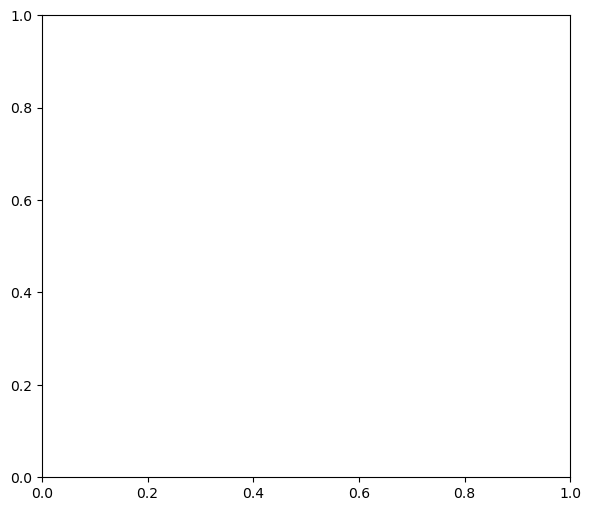

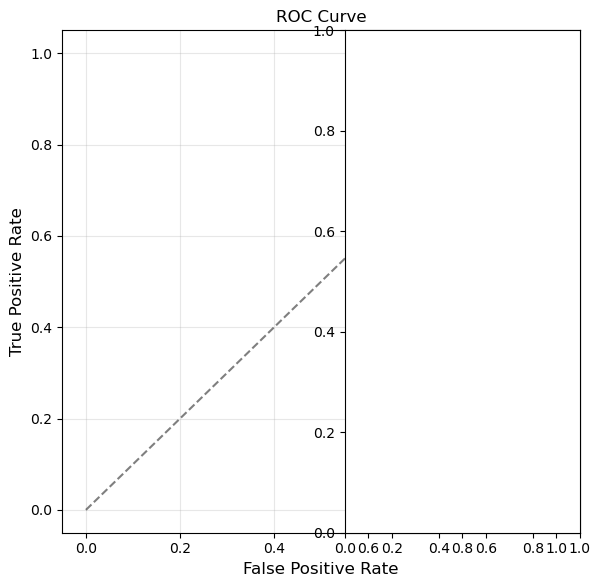

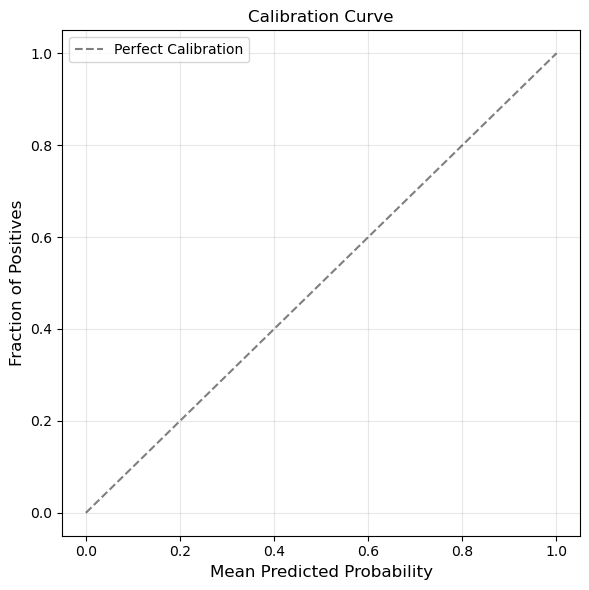

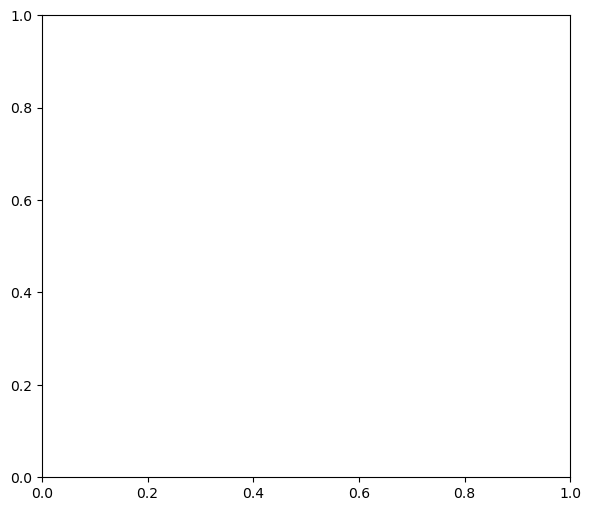

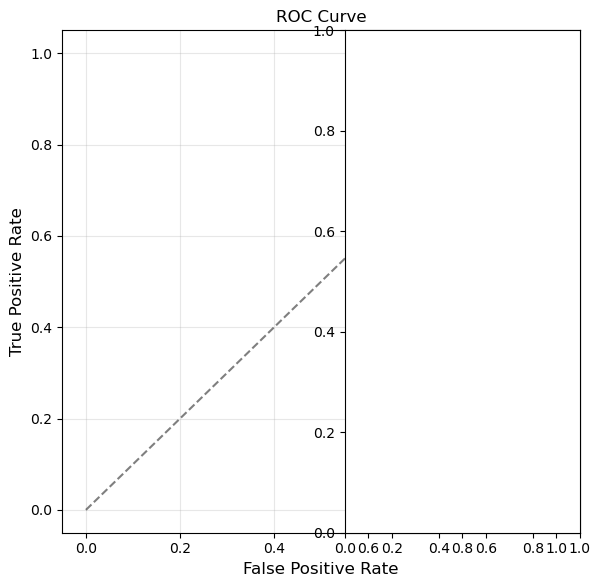

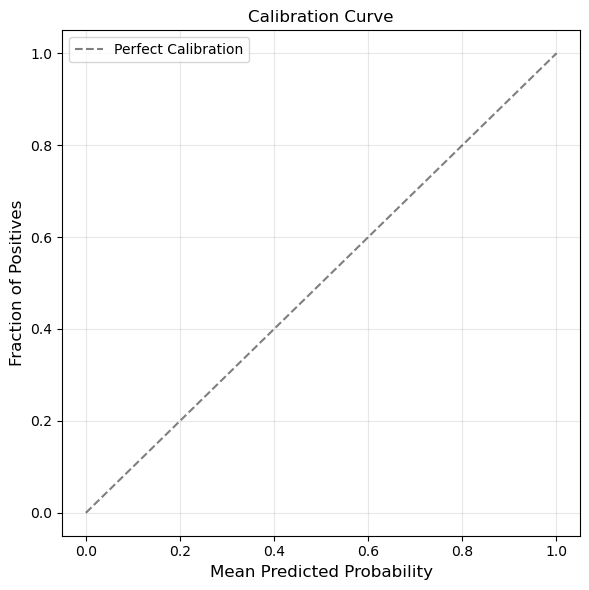

In [21]:
viz = RiskVisualizer()

plt.figure(figsize=(15, 6))

# ROC Curve
plt.subplot(1, 2, 1)
viz.plot_roc_curves({'XGBoost': xgb_results}, figsize=(6, 6))
plt.title("ROC Curve")

# Calibration Curve
plt.subplot(1, 2, 2)
viz.plot_calibration_curves({'XGBoost': xgb_results}, figsize=(6, 6))
plt.title("Calibration Curve")

plt.tight_layout()
plt.show()
viz = RiskVisualizer()

plt.figure(figsize=(15, 6))

# ROC Curve
plt.subplot(1, 2, 1)
viz.plot_roc_curves({'XGBoost': xgb_results}, figsize=(6, 6))
plt.title("ROC Curve")

# Calibration Curve
plt.subplot(1, 2, 2)
viz.plot_calibration_curves({'XGBoost': xgb_results}, figsize=(6, 6))
plt.title("Calibration Curve")

plt.tight_layout()
plt.show()

Top 10 Features (Check for Leakage):


,Feature,Importance
19,loan_to_income,0.191206
4,fico_range_low,0.167389
9,acc_open_past_24mths,0.117877
6,inq_last_6mths,0.092730
8,open_il_12m,0.060968
0,funded_amnt,0.053313
3,dti,0.052328
13,tot_hi_cred_lim,0.049308
2,installment,0.039996
1,funded_amnt_inv,0.038420


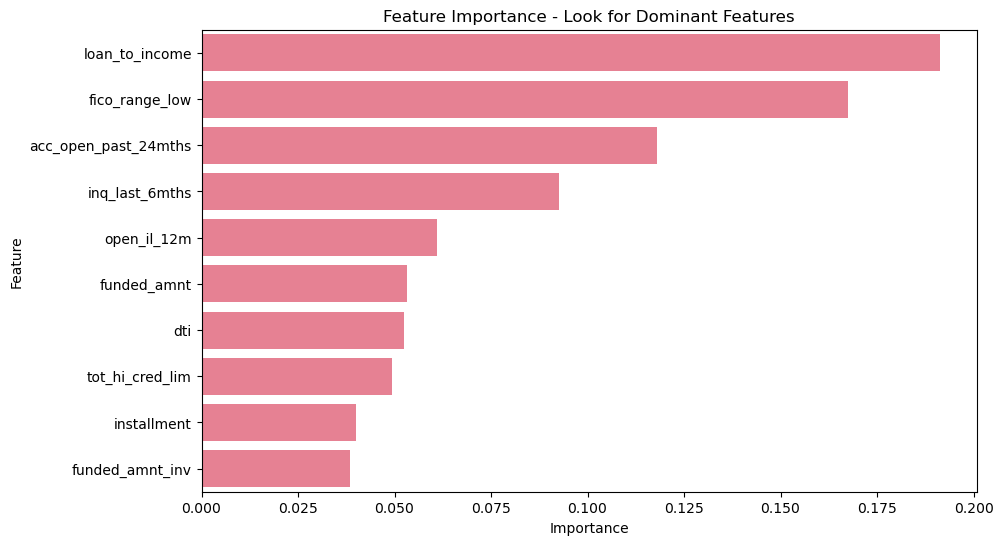

In [22]:
# Get feature importance from the trained XGBoost model
importance = xgb_model.named_steps['model'].feature_importances_
features = selected_features

# Create a DataFrame
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importance})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

# Show top 10 features
print("Top 10 Features (Check for Leakage):")
display(feat_imp.head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(10))
plt.title("Feature Importance - Look for Dominant Features")
plt.show()

Running Monte Carlo Simulation for Credit VaR...
Credit VaR (99.9%): $16,174,781,358.82
Expected Shortfall: $17,290,080,134.39
Credit VaR (99.9%): $16,174,781,358.82
Expected Shortfall: $17,290,080,134.39
Plot saved to: c:\Users\xzhaox\Desktop\OneDrive\risk_management\risk-management\notebooks\..\portfolio_loss_distribution.png
Plot saved to: c:\Users\xzhaox\Desktop\OneDrive\risk_management\risk-management\notebooks\..\portfolio_loss_distribution.png


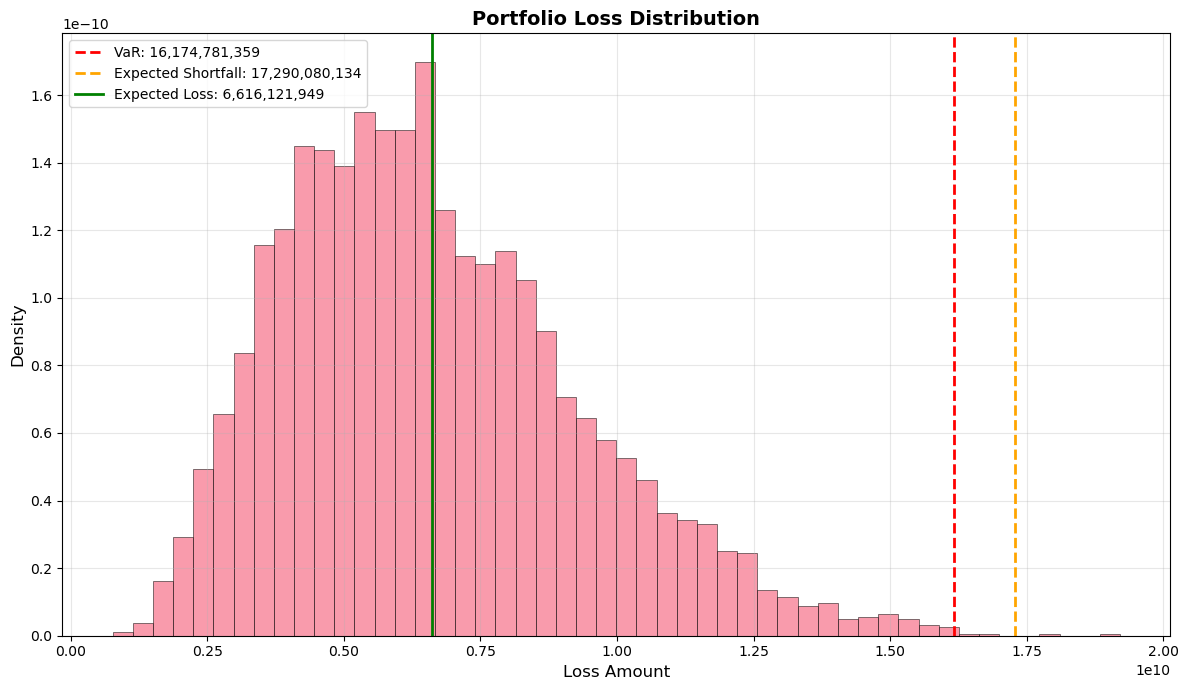

In [23]:
# Monte Carlo Simulation for Portfolio VaR
print("Running Monte Carlo Simulation for Credit VaR...")
mc_results = risk_calc.calculate_credit_var_monte_carlo(
    exposures=exposures,
    pds=pds,
    lgds=lgds,
    n_simulations=5000  # 5000 simulations for better resolution
)

print(f"Credit VaR (99.9%): ${mc_results['credit_var']:,.2f}")
print(f"Expected Shortfall: ${mc_results['expected_shortfall']:,.2f}")

# Plot Loss Distribution and Save
save_path = os.path.join(os.getcwd(), '..', 'portfolio_loss_distribution.png')
viz.plot_loss_distribution(
    losses=mc_results['loss_distribution'],
    var_level=mc_results['credit_var'],
    expected_shortfall=mc_results['expected_shortfall'],
    figsize=(12, 7),
    save_path=save_path
)
print(f"Plot saved to: {save_path}")
plt.show()